## MedMNIST Dataset
18x Standardized Datasets for 2D and 3D Biomedical Image Classification with Multiple Size Options: 28 (MNIST-Like), 64, 128, and 224 pixels.  

The MedMNIST dataset consists of 12 pre-processed 2D datasets and 6 pre-processed 3D datasets from selected sources covering primary data modalities (e.g., X-Ray, OCT, Ultrasound, CT, Electron Microscope), diverse classification tasks (binary/multi-class, ordinal regression and multi-label) and data scales (from 100 to 100,000). 


![MedMNIST Dataset](https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/assets/medmnistv2.jpg)

> Jiancheng Yang, Rui Shi, Donglai Wei, Zequan Liu, Lin Zhao, Bilian Ke, Hanspeter Pfister, Bingbing Ni. Yang, Jiancheng, et al. "MedMNIST v2-A large-scale lightweight benchmark for 2D and 3D biomedical image classification." Scientific Data, 2023.

> Jiancheng Yang, Rui Shi, Bingbing Ni. "MedMNIST Classification Decathlon: A Lightweight AutoML Benchmark for Medical Image Analysis". IEEE 18th International Symposium on Biomedical Imaging (ISBI), 2021.

### BloodMNIST dataset

| MedMNIST2D | Data Modality          | Tasks (# Classes/Labels) | # Samples | # Training / Validation / Test  |
|------------|------------------------|--------------------------|-----------|---------------------------------|
| BloodMNIST | Blood Cell Microscope   | Multi-Class (8)           | 17,092    | 11,959 / 1,712 / 3,421          |




`Goal: Build a simple CNN to classify images of blood cells to their correct labels.`


### Download and load the dataset

In [1]:
from medmnist import BloodMNIST
from medmnist import INFO

train_dataset = BloodMNIST(split="train", download=True)
test_dataset = BloodMNIST(split="test", download=True)

labels = INFO["bloodmnist"]['label']
print(train_dataset)

Using downloaded and verified file: C:\Users\rodani\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\rodani\.medmnist\bloodmnist.npz
Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 11959
    Root location: C:\Users\rodani\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into train

In [2]:
labels 

{'0': 'basophil',
 '1': 'eosinophil',
 '2': 'erythroblast',
 '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)',
 '4': 'lymphocyte',
 '5': 'monocyte',
 '6': 'neutrophil',
 '7': 'platelet'}

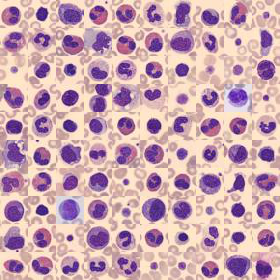

In [3]:
train_dataset.montage(length=10)

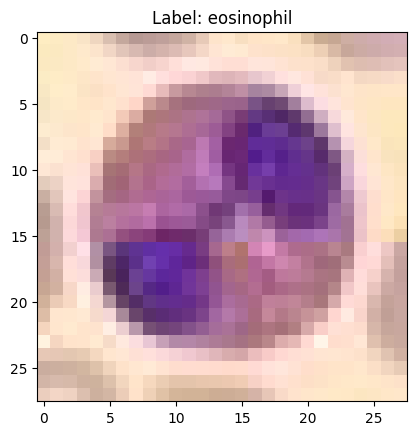

In [4]:
import matplotlib.pyplot as plt
import numpy as np

idx = np.random.randint(0,1000)
image = train_dataset[idx][0]
l = str(train_dataset[idx][1][0])
image_label = labels[l]

image_np = np.array(image)


# Plot the image
plt.imshow(image_np)
plt.title(f"Label: {image_label}")
plt.show()


In [5]:
from torch.utils import data
from torchvision import transforms

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = BloodMNIST(split="train", transform=data_transform)
test_dataset = BloodMNIST(split="test", transform=data_transform)

train_loader = data.DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 11959
Number of test samples: 3421


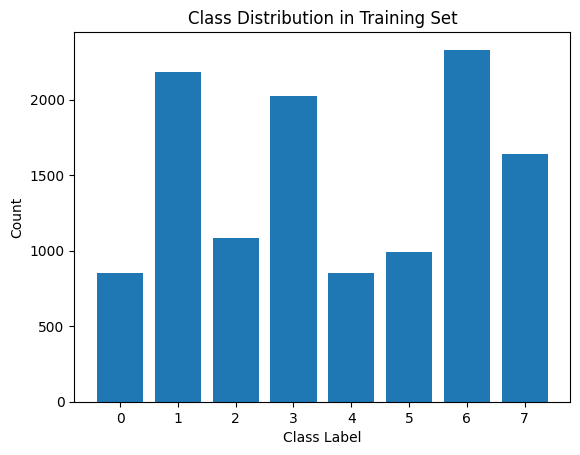

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_loader is your DataLoader
class_counts = np.zeros(len(labels))  # Replace num_classes with the total number of classes

# Iterate over the data loader and accumulate class counts
for data, targets in train_loader:
    # Assuming targets contains the labels
    for label in targets:
        class_counts[label] += 1

# Plot histogram
plt.bar(range(len(labels)), class_counts)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Distribution in Training Set')
plt.show()

### Build a simple CNN

In [7]:
import torch
from torch import nn


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(16 * 14 * 14, 64) 
        self.fc2 = nn.Linear(64, 8)  

        #self.conv1 = nn.Conv2d(3, 7, kernel_size=3, stride=1, padding=1)
        #self.conv2 = nn.Conv2d(7, 21, kernel_size=3, stride=1, padding=1)
        #self.fc1 = nn.Linear(21 * 7 * 7, 64)                           
        #self.fc2 = nn.Linear(64, 8)  

        #self.conv1 = nn.Conv2d(3, 7, kernel_size=3, stride=1, padding=1)
        #self.conv2 = nn.Conv2d(7, 21, kernel_size=3, stride=1, padding=1)
        #self.fc1 = nn.Linear(21 * 7 * 7, 128)
        #self.fc2 = nn.Linear(128, 64)
        #self.fc3 = nn.Linear(64, 8)

        self.flatten = nn.Flatten()                                    

    def forward(self, x):
        x = torch.relu(self.conv1(x))                                   
        x = torch.max_pool2d(x, kernel_size=2, stride=2)

        #x = torch.relu(self.conv2(x))
        #x = torch.max_pool2d(x, kernel_size=2, stride=2)

        x = self.flatten(x)                                
        x = torch.relu(self.fc1(x)) 
        x = self.fc2(x)  
                                             
        #x = torch.relu(self.fc2(x))
        #x = self.fc3(x)                                             
        return x
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
model = SimpleCNN()
num_params = count_parameters(model)
print(f"Total number of parameters: {num_params}")

Total number of parameters: 201736


### Training our model

In [9]:
from torch import optim

model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
#class_weights= class_counts / class_counts.sum()
#criterion = nn.CrossEntropyLoss(weight=torch.Tensor(class_weights))
 
optimizer = optim.SGD(model.parameters())
epochs = 5
train_losses = []
test_losses = []

for epoch in range(epochs):

    # training
    model.train()
    train_loss = 0.0

    for inputs, targets in train_loader:
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        targets = targets.squeeze_()
        loss = criterion(outputs, targets)      
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # testing

    model.eval()  
    test_loss = 0.0
    with torch.no_grad():  # No gradient computation
        for inputs, targets in test_loader:
            outputs = model(inputs)  
            targets = targets.squeeze() 
            loss = criterion(outputs, targets)  
            test_loss += loss.item()  
    
    avg_test_loss = test_loss / len(test_loader)  
    test_losses.append(avg_test_loss)  
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')


Epoch [1/5], Train Loss: 1.9311, Test Loss: 1.7946
Epoch [2/5], Train Loss: 1.5920, Test Loss: 1.3997
Epoch [3/5], Train Loss: 1.2591, Test Loss: 1.1425
Epoch [4/5], Train Loss: 1.0607, Test Loss: 0.9957
Epoch [5/5], Train Loss: 0.9428, Test Loss: 0.9082


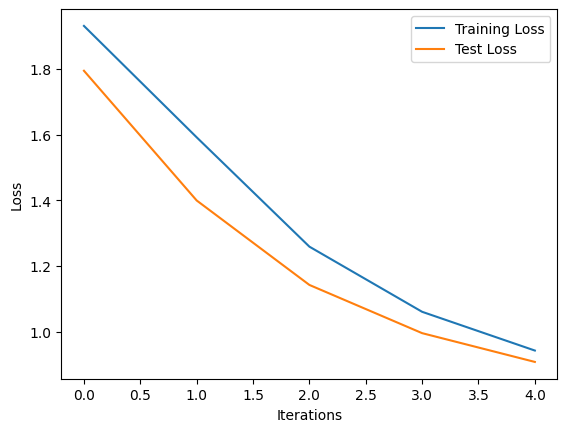

In [10]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

## Testing and evaluation

Test Accuracy: 68.81%


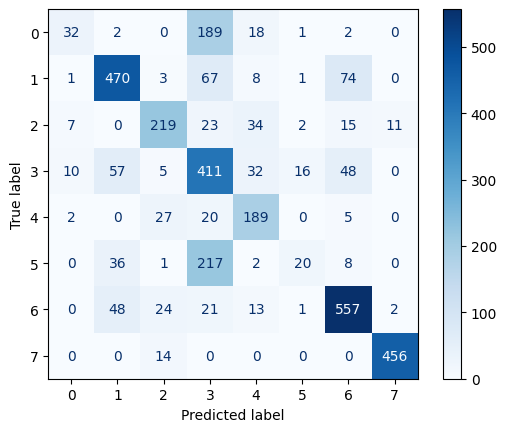

              precision    recall  f1-score   support

    basophil       0.62      0.13      0.22       244
  eosinophil       0.77      0.75      0.76       624
  erythrobla       0.75      0.70      0.73       311
  immature g       0.43      0.71      0.54       579
  lymphocyte       0.64      0.78      0.70       243
    monocyte       0.49      0.07      0.12       284
  neutrophil       0.79      0.84      0.81       666
    platelet       0.97      0.97      0.97       470

    accuracy                           0.69      3421
   macro avg       0.68      0.62      0.61      3421
weighted avg       0.70      0.69      0.66      3421



In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

model.eval()

y_true = []
y_score = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)  
        targets = targets.squeeze()
        
        y_true.extend(targets.tolist()) 
        y_score.extend(outputs.argmax(dim=1).tolist()) 
    
test_accuracy = (torch.tensor(y_true) == torch.tensor(y_score)).float().mean().item()
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

cm = confusion_matrix(y_true, y_score)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(8)])
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(y_true, y_score, target_names=[labels[str(i)][:10] for i in range(8)]))

## MNIST Digits classification using Multi Layer Perceptron
A Multi-Layer Perceptron (MLP) is a feedforward neural network with multiple layers of neurons that utilize weighted connections and activation functions to learn complex mappings from inputs to outputs

### Load MNIST

In [36]:
import gzip
import os
import numpy as np
import struct


def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte.gz')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte.gz')

    with gzip.open(labels_path, 'rb') as lbpath:
        _, _ = struct.unpack('>II', lbpath.read(8))
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8)

    with gzip.open(images_path, 'rb') as imgpath:
        _, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.frombuffer(imgpath.read(), dtype=np.uint8).reshape(num, rows*cols)

    return images, labels

# Load the dataset
mnist_path = '../supplemental_material/MNIST'
X_train, y_train = load_mnist(mnist_path, kind='train')
X_test, y_test = load_mnist(mnist_path, kind='t10k')

print(f"Training set shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Test set shape: {X_test.shape}, Test labels shape: {y_test.shape}")    

Training set shape: (60000, 784), Training labels shape: (60000,)
Test set shape: (10000, 784), Test labels shape: (10000,)


### Define MLP


In [38]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)  

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)  
        return out

### Preprocess MNIST

In [39]:
from torch.utils.data import DataLoader, TensorDataset


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)  

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

### Setting up training

In [40]:
input_size = X_train.shape[1]  # 28*28 for MNIST
hidden_size = 128 # number of neurons in the hidden layer
output_size = 10  # number of classes

model = MLP(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()  # Cross Entropy Loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10
train_losses = []
test_losses = []

### Training

In [41]:
for epoch in range(epochs):

    # training
    model.train()
    train_loss = 0.0

    for inputs, targets in train_loader:
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        targets = targets.squeeze_()
        loss = criterion(outputs, targets)      
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # testing

    model.eval()  
    test_loss = 0.0
    with torch.no_grad():  # No gradient computation
        for inputs, targets in test_loader:
            outputs = model(inputs)  
            targets = targets.squeeze() 
            loss = criterion(outputs, targets)  
            test_loss += loss.item()  
    
    avg_test_loss = test_loss / len(test_loader)  
    test_losses.append(avg_test_loss)  
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

# Save the model weights
save_path = os.path.join("data", "weights", "MLP")
os.makedirs(save_path, exist_ok=True)  
torch.save(model.state_dict(), os.path.join(save_path, "MNIST.pth"))

Epoch [1/10], Train Loss: 2.0978, Test Loss: 2.0876
Epoch [2/10], Train Loss: 2.0856, Test Loss: 2.0796
Epoch [3/10], Train Loss: 2.0855, Test Loss: 2.0843
Epoch [4/10], Train Loss: 2.0280, Test Loss: 2.0018
Epoch [5/10], Train Loss: 1.9948, Test Loss: 1.9901
Epoch [6/10], Train Loss: 1.9975, Test Loss: 1.9869
Epoch [7/10], Train Loss: 2.0003, Test Loss: 1.9902
Epoch [8/10], Train Loss: 1.9878, Test Loss: 1.9829
Epoch [9/10], Train Loss: 1.9849, Test Loss: 1.9889
Epoch [10/10], Train Loss: 1.9912, Test Loss: 2.0052


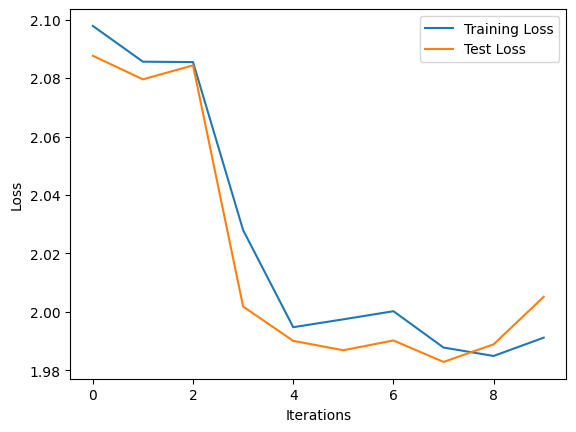

In [42]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

Test Accuracy: 45.60%


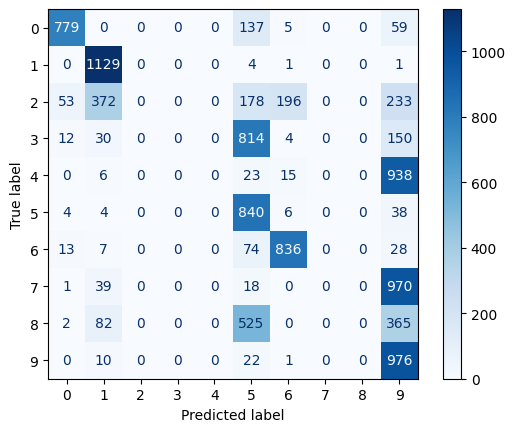

              precision    recall  f1-score   support

           0       0.90      0.79      0.84       980
           1       0.67      0.99      0.80      1135
           2       1.00      0.00      0.00      1032
           3       1.00      0.00      0.00      1010
           4       1.00      0.00      0.00       982
           5       0.32      0.94      0.48       892
           6       0.79      0.87      0.83       958
           7       1.00      0.00      0.00      1028
           8       1.00      0.00      0.00       974
           9       0.26      0.97      0.41      1009

    accuracy                           0.46     10000
   macro avg       0.79      0.46      0.34     10000
weighted avg       0.80      0.46      0.34     10000



In [43]:
model.eval()

y_true = []
y_score = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)  
        targets = targets.squeeze()
        
        y_true.extend(targets.tolist()) 
        y_score.extend(outputs.argmax(dim=1).tolist()) 
    
test_accuracy = (torch.tensor(y_true) == torch.tensor(y_score)).float().mean().item()
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

cm = confusion_matrix(y_true, y_score)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(y_true, y_score, zero_division=1))

### Digit Classification with LeNet-5
LeNet is a convolutional neural network (CNN) architecture that employs convolutional and subsampling layers to extract features from images, followed by fully connected layers for classification. It was build specifically forthe MNIST dataset.

> LeCun, Yann, et al. "Comparison of learning algorithms for handwritten digit recognition." International conference on artificial neural networks. Vol. 60. No. 1. 1995.

![LeNet-5](https://upload.wikimedia.org/wikipedia/commons/thumb/3/35/LeNet-5_architecture.svg/1920px-LeNet-5_architecture.svg.png)



> Image from: By Zhang, Aston and Lipton, Zachary C. and Li, Mu and Smola, Alexander J. - https://github.com/d2l-ai/d2l-en

In [19]:
# Define LeNet-5 architecture
class LeNet5(nn.Module):
    def __init__(self, channels=1, output_size=10):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(channels, 6, kernel_size=5, stride=1, padding=2)  # output size: 6x28x28
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)  # no padding, output size: 16x10x10       
        self.fc1 = nn.Linear(16 * 5 * 5, 120)                            
        self.fc2 = nn.Linear(120, 84)                                   
        self.fc3 = nn.Linear(84, output_size)                                     # Output layer for 10 classes

    def forward(self, x):
        x = torch.relu(self.conv1(x))  
        x = torch.max_pool2d(x, kernel_size=2, stride=2)  
        x = torch.relu(self.conv2(x))  
        x = torch.max_pool2d(x, kernel_size=2, stride=2) 
        x = x.view(-1, 16 * 5 * 5)  
        x = torch.relu(self.fc1(x))  
        x = torch.relu(self.fc2(x))  
        x = self.fc3(x) 
        return x

In [20]:
model = LeNet5(channels=1)
num_params = count_parameters(model)
print(f"Total number of parameters: {num_params}")

Total number of parameters: 61706


### Preprocessing the dataset from 1d to 2d

In [21]:
# reshape the data
print(X_train_tensor.shape, y_train_tensor.shape)

X_train_tensor = X_train_tensor.view(-1, 1, 28, 28)
X_test_tensor = X_test_tensor.view(-1, 1, 28, 28)

print(X_train_tensor.shape, X_test_tensor.shape)

torch.Size([60000, 784]) torch.Size([60000])
torch.Size([60000, 1, 28, 28]) torch.Size([10000, 1, 28, 28])


In [22]:
# Create the data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

### Training setup

In [23]:
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10
train_losses = []
test_losses = []

In [24]:
for epoch in range(epochs):

    # training
    model.train()
    train_loss = 0.0

    for inputs, targets in train_loader:
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        targets = targets.squeeze_()
        loss = criterion(outputs, targets)      
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # testing

    model.eval()  
    test_loss = 0.0
    with torch.no_grad():  # No gradient computation
        for inputs, targets in test_loader:
            outputs = model(inputs)  
            targets = targets.squeeze() 
            loss = criterion(outputs, targets)  
            test_loss += loss.item()  
    
    avg_test_loss = test_loss / len(test_loader)  
    test_losses.append(avg_test_loss)  
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

# Save the model weights
save_path = os.path.join("data", "weights", "LeNet5")
os.makedirs(save_path, exist_ok=True)  
torch.save(model.state_dict(), os.path.join(save_path, "MNIST.pth"))

Epoch [1/10], Train Loss: 0.1955, Test Loss: 0.0700
Epoch [2/10], Train Loss: 0.0670, Test Loss: 0.0568
Epoch [3/10], Train Loss: 0.0514, Test Loss: 0.0632
Epoch [4/10], Train Loss: 0.0410, Test Loss: 0.0561
Epoch [5/10], Train Loss: 0.0381, Test Loss: 0.0458
Epoch [6/10], Train Loss: 0.0315, Test Loss: 0.0689
Epoch [7/10], Train Loss: 0.0306, Test Loss: 0.0429
Epoch [8/10], Train Loss: 0.0257, Test Loss: 0.0381
Epoch [9/10], Train Loss: 0.0244, Test Loss: 0.0521
Epoch [10/10], Train Loss: 0.0222, Test Loss: 0.0463


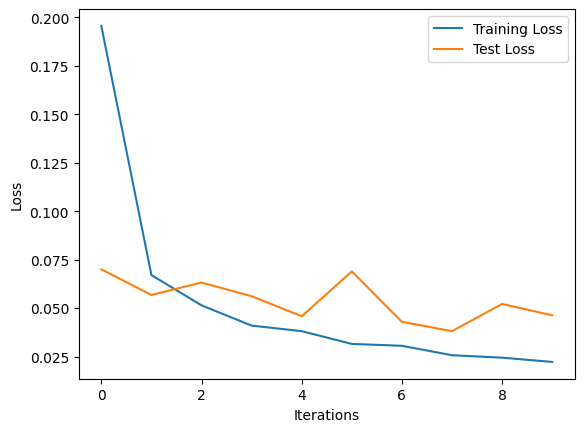

In [25]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

### Testing and evaluation

Test Accuracy: 98.77%


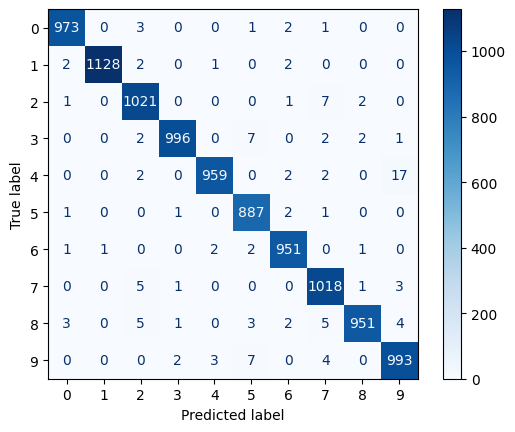

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.98      0.99      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.99      0.98      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.98      1028
           8       0.99      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [26]:
model.eval()

y_true = []
y_score = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)  
        targets = targets.squeeze()
        
        y_true.extend(targets.tolist()) 
        y_score.extend(outputs.argmax(dim=1).tolist()) 
    
test_accuracy = (torch.tensor(y_true) == torch.tensor(y_score)).float().mean().item()
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

cm = confusion_matrix(y_true, y_score)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(y_true, y_score, zero_division=1))

### On LeNet-5 performance

LeNet-5 performs extremely well on the MNIST dataset with a relative small amount of parameters. 
This result is achieved thanks to emerging properties of convolutional and max pooling layers:
- **invariance** to small transformation (translation, scale, rotation)
- **noise resistance**, where last layers are not affected by structured noise 

Head to [LeNet-5 Demo](https://yann.lecun.com/exdb/lenet/translation.html) to see visually how small perturbations of the input images affect the classification results.

> Credit: Yann LeCun, https://yann.lecun.com/index.html



### How filters change with training

In [27]:
new_model = LeNet5(channels=1)
new_filters_conv1 = new_model.conv1.weight.data.numpy()
trained_filters_conv1 = model.conv1.weight.data.numpy()

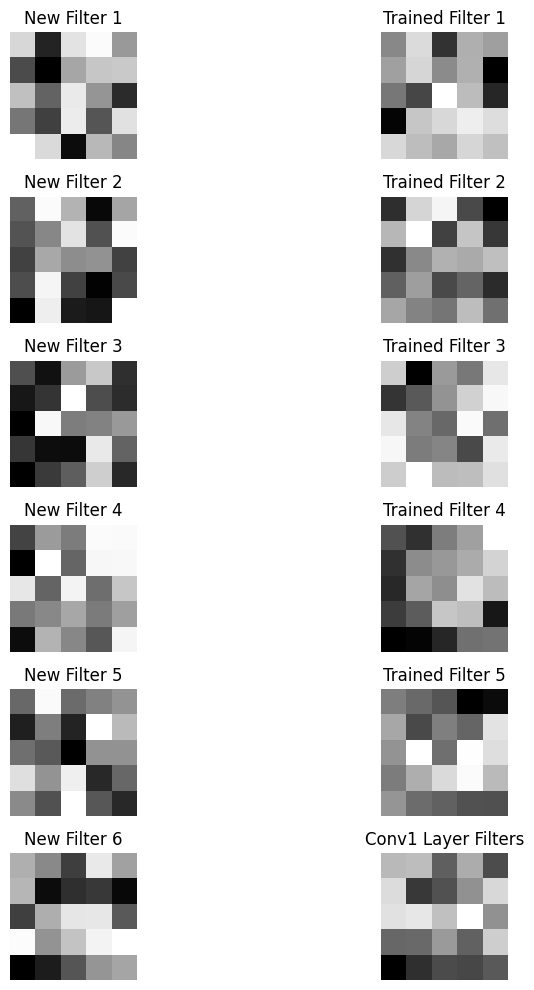

In [28]:
plt.figure(figsize=(10, 10))  

for i in range(new_filters_conv1.shape[0]):
    plt.subplot(6, 2, 2 * i + 1)  
    plt.imshow(new_filters_conv1[i][0], cmap='gray')
    plt.title(f'New Filter {i + 1}')
    plt.axis('off')

    plt.subplot(6, 2, 2 * i + 2)  
    plt.imshow(trained_filters_conv1[i][0], cmap='gray')
    plt.title(f'Trained Filter {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.title('Conv1 Layer Filters')
plt.show()


## Transfer learning

`Goal: Use the LeNet-5 model to classify images of handwritten digits as either 0 or 1. Next, we will apply the same model to a different task, such as classifying images of another pair of digits, for example, 3 vs. 4.`

### Data preprocessing

In [29]:
# filtering data
digits = [0, 1]
train_filter = np.isin(y_train, digits)
test_filter = np.isin(y_test, digits)

X_train_filtered = X_train[train_filter]
y_train_filtered = y_train[train_filter]

X_test_filtered = X_test[test_filter]
y_test_filtered = y_test[test_filter]

# converting to tensors
X_train_tensor = torch.tensor(X_train_filtered, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_filtered, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_filtered, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_filtered, dtype=torch.long)

# reshaping the data
X_train_tensor = X_train_tensor.view(-1, 1, 28, 28)
X_test_tensor = X_test_tensor.view(-1, 1, 28, 28)

# creating the data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

### Training Setup

In [30]:
model = LeNet5(channels=1, output_size=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 3
train_losses = []
test_losses = []

In [31]:
for epoch in range(epochs):

    # training
    model.train()
    train_loss = 0.0

    for inputs, targets in train_loader:
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        targets = targets.squeeze_()
        loss = criterion(outputs, targets)      
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # testing

    model.eval()  
    test_loss = 0.0
    with torch.no_grad():  # No gradient computation
        for inputs, targets in test_loader:
            outputs = model(inputs)  
            targets = targets.squeeze() 
            loss = criterion(outputs, targets)  
            test_loss += loss.item()  
    
    avg_test_loss = test_loss / len(test_loader)  
    test_losses.append(avg_test_loss)  
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')


Epoch [1/3], Train Loss: 0.0218, Test Loss: 0.0027
Epoch [2/3], Train Loss: 0.0023, Test Loss: 0.0042
Epoch [3/3], Train Loss: 0.0044, Test Loss: 0.0021


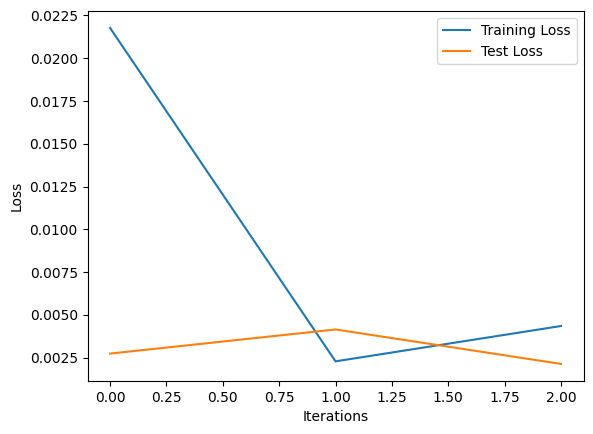

In [32]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

Test Accuracy: 99.95%


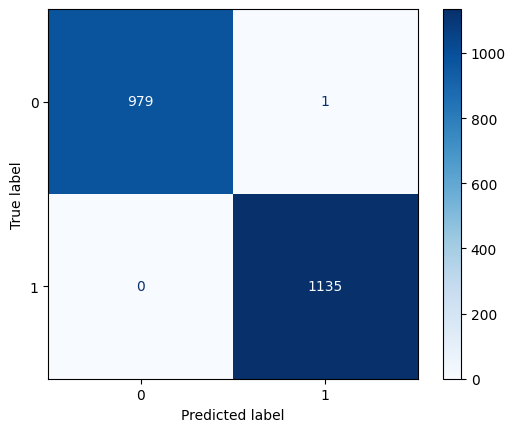

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135

    accuracy                           1.00      2115
   macro avg       1.00      1.00      1.00      2115
weighted avg       1.00      1.00      1.00      2115



In [33]:
model.eval()

y_true = []
y_score = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)  
        targets = targets.squeeze()
        
        y_true.extend(targets.tolist()) 
        y_score.extend(outputs.argmax(dim=1).tolist()) 
    
test_accuracy = (torch.tensor(y_true) == torch.tensor(y_score)).float().mean().item()
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

cm = confusion_matrix(y_true, y_score)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[digits[i] for i in range(2)])
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(y_true, y_score, zero_division=1))

### Preprocess the new dataset of 3 and 4 digits 

In [34]:
# filtering data
digits = [6, 7]
train_filter = np.isin(y_train, digits)
test_filter = np.isin(y_test, digits)

X_train_filtered = X_train[train_filter]
y_train_filtered = y_train[train_filter]

X_test_filtered = X_test[test_filter]
y_test_filtered = y_test[test_filter]

# converting to tensors
X_train_tensor = torch.tensor(X_train_filtered, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_filtered, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_filtered, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_filtered, dtype=torch.long)

# reshaping the data
X_train_tensor = X_train_tensor.view(-1, 1, 28, 28)
X_test_tensor = X_test_tensor.view(-1, 1, 28, 28)

# creating the data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

Test Accuracy: 84.44%


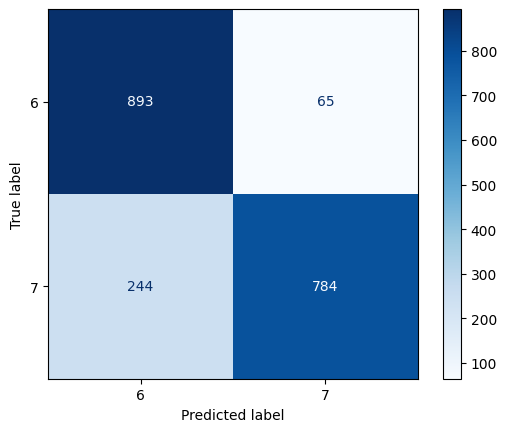

              precision    recall  f1-score   support

           6       0.79      0.93      0.85       958
           7       0.92      0.76      0.84      1028

    accuracy                           0.84      1986
   macro avg       0.85      0.85      0.84      1986
weighted avg       0.86      0.84      0.84      1986



In [35]:
model.eval()

y_true = []
y_score = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)  
        targets = targets.squeeze()
        
        y_true.extend(targets.tolist()) 
        y_score.extend((outputs.argmax(dim=1) + 6).tolist()) 
    
test_accuracy = (torch.tensor(y_true) == torch.tensor(y_score)).float().mean().item()
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

cm = confusion_matrix(y_true, y_score)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[digits[i] for i in range(2)])
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(y_true, y_score, zero_division=1))